<a href="https://colab.research.google.com/github/pati-dev/predict-shopping-intention/blob/master/predict_purchase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boot

In [0]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer

# Load Data

In [0]:
shop = pd.read_csv("/content/drive/My Drive/Personal/IUB/Job apps/Capgemini/online_shoppers_intention.csv")

In [7]:
shop.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Preprocessing

In [6]:
shop.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

## Page views

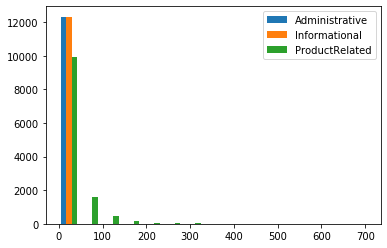

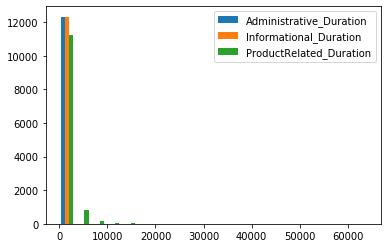

In [51]:
pages = ['Administrative',
         'Informational',
         'ProductRelated']

page_durations = ['Administrative_Duration',
                  'Informational_Duration',
                  'ProductRelated_Duration']

x_pages = shop.loc[:, pages].values
x_page_durations = shop.loc[:, page_durations].values

plt.hist(x_pages, bins=15, label=pages)
plt.legend()
plt.show()
plt.hist(x_page_durations, bins=20, label=page_durations)
plt.legend()
plt.show()

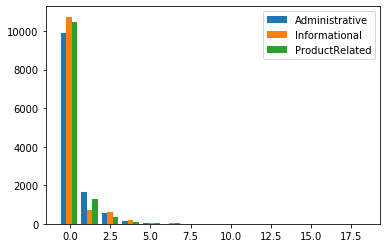

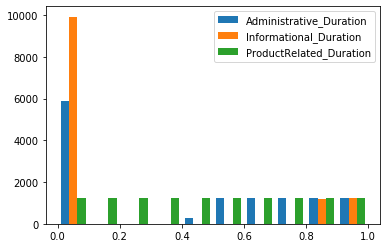

In [56]:
x_pages = StandardScaler().fit_transform(x_pages)
plt.hist(x_pages, bins=15, label=pages)
plt.legend()
plt.show()

x_page_durations = QuantileTransformer(output_distribution='uniform').fit_transform(x_page_durations)
plt.hist(x_page_durations, label=page_durations)
plt.legend()
plt.show()

In [0]:
features = ['Administrative',
            'Administrative_Duration',
            'Informational',
            'Informational_Duration',
            'ProductRelated',
            'ProductRelated_Duration',
            'BounceRates',
            'ExitRates',
            'PageValues',
            'SpecialDay',
            'VisitorType',
            'Weekend',]